In [1]:
import pandas as pd
import numpy as np
from keras.layers import Dense, Flatten
from keras.layers import Input
from keras.models import Model
import General.DL_read_data as read_data
import General.Run_models as run
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.layers.convolutional import MaxPooling1D, UpSampling1D
from keras.layers.convolutional import Conv1D
from sklearn.model_selection import train_test_split
import keras
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
import General.write_results_csv as wr
import General.UTILS as utils
from keras.layers import BatchNormalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# from imblearn.under_sampling import RandomUnderSampler
# import time


2021-11-23 08:28:46.907741: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-23 08:28:46.907820: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


##### Read Data

In [2]:
file_to_save = 'results/resultados.csv'
path = 'Data_to_work'

In [3]:
# read unlabeled data as panda Dataframe
usc_df = pd.read_csv(path + '/USC-HAD_ordered_20hz.csv')
print(np.unique(usc_df['Activity']))

['downstairs' 'run' 'running' 'sit' 'sitting' 'stand' 'standing'
 'upstairs' 'walk-left' 'walking']


In [4]:
# Elimino las actividades que no me interesan
others = usc_df[usc_df['Activity'] == 'Others'].index
walk_left = usc_df[usc_df['Activity'] == 'walk-left'].index
usc_df.drop(others, inplace = True)
usc_df.drop(walk_left, inplace = True)
print(np.unique(usc_df['Activity']))

['downstairs' 'run' 'running' 'sit' 'sitting' 'stand' 'standing'
 'upstairs' 'walking']


In [5]:
# Coloco las actividades en el mismo orden que WISDM
usc_df.loc[usc_df.Activity == "walking", "ActivityEncoded"] = 5
usc_df.loc[usc_df['Activity'] == 'running', 'ActivityEncoded'] = 1
usc_df.loc[usc_df['Activity'] == 'run', 'ActivityEncoded'] = 1
usc_df.loc[usc_df['Activity'] == 'sitting', 'ActivityEncoded'] = 2
usc_df.loc[usc_df['Activity'] == 'sit', 'ActivityEncoded'] = 2
usc_df.loc[usc_df['Activity'] == 'standing', 'ActivityEncoded'] = 3
usc_df.loc[usc_df['Activity'] == 'stand', 'ActivityEncoded'] = 3
usc_df.loc[usc_df['Activity'] == 'downstairs', 'ActivityEncoded'] = 0
usc_df.loc[usc_df['Activity'] == 'upstairs', 'ActivityEncoded'] = 4
# usc_df.to_csv(path + '/USC-HAD_Ordered.csv')

In [6]:
# usc_df.groupby(usc_df['Activity']).head()

In [7]:
# Show how many training examples exist for each of the six activities
# usc_df['ActivityEncoded'].value_counts().plot(kind='bar',
#                                    title='Training Examples by Activity Type')
# plt.show()

In [8]:
# read labeled dataset as pandas Dataframe
wisdm_df = pd.read_csv(path + '/WISDM.csv')
# Normalize the data
scaler = MinMaxScaler()
scaler.fit(wisdm_df[['x-axis', 'y-axis', 'z-axis']])
wisdm_df[['x-axis', 'y-axis', 'z-axis']] = scaler.transform(wisdm_df[['x-axis', 'y-axis', 'z-axis']])

In [9]:
# Normalization based on training data
scaler_unlabeled = MinMaxScaler()
scaler_unlabeled.fit(usc_df[['x-axis', 'y-axis', 'z-axis']])
usc_df[['x-axis', 'y-axis', 'z-axis']] = scaler_unlabeled.transform(usc_df[['x-axis', 'y-axis', 'z-axis']])

In [10]:
# wisdm_df.groupby(wisdm_df['activity']).head()

In [11]:
# Show how many training examples exist for each of the six activities
# wisdm_df['ActivityEncoded'].value_counts().plot(kind='bar',
#                                    title='Training Examples by Activity Type')
# plt.show()

#### Class Imbalance

In [12]:
usc_df =  utils.class_imbalance(usc_df)
wisdm_df = utils.class_imbalance(wisdm_df)

Class=1, total=98700, percentage=13.478
Class=2, total=88250, percentage=12.051
Class=3, total=130750, percentage=17.855
Class=4, total=118000, percentage=16.114
Class=5, total=105900, percentage=14.461
Class=6, total=190700, percentage=26.041
Counter({5: 190700, 2: 130750, 3: 118000, 4: 105900, 0: 98700, 1: 88250})
Class=1, total=190700, percentage=16.667
Class=2, total=190700, percentage=16.667
Class=3, total=190700, percentage=16.667
Class=4, total=190700, percentage=16.667
Class=5, total=190700, percentage=16.667
Class=6, total=190700, percentage=16.667
Counter({1: 190700, 4: 190700, 0: 190700, 5: 190700, 3: 190700, 2: 190700})
Class=1, total=100427, percentage=9.145
Class=2, total=342176, percentage=31.158
Class=3, total=59939, percentage=5.458
Class=4, total=48395, percentage=4.407
Class=5, total=122869, percentage=11.188
Class=6, total=424397, percentage=38.645
Counter({5: 424397, 1: 342176, 4: 122869, 0: 100427, 2: 59939, 3: 48395})
Class=1, total=424397, percentage=16.667
Clas

##### Take percentage of Unlabeled data to train the model

Tenemos que tener en cuenta que en ese porcentaje de datos para entrenar el autoencoder, tenemos que coger la misma cantidad de clases. Es decir, en ese cacho de USC-HAD deben aparecer todas las actividades

##### Create Time Windows 3D Tensor

In [13]:
# generate time windows to execute the algorithm by batch
time_window = 200  # this dataset frequency 100hz 
overlap = 20  # 1 second of overlap
X_wisdm, Y_wisdm = read_data.create_windows_and_labels(time_window, overlap, wisdm_df)
X_usc, Y_usc = read_data.create_windows_and_labels(time_window, overlap, usc_df)

In [14]:
# Train Test Split with stratified number of classes
from sklearn.model_selection import StratifiedShuffleSplit

# We will train with 20% of WISDM our autoencoder and Classifier
X_train_wisdm, X_test_wisdm, Y_train_wisdm, Y_test_wisdm = train_test_split(X_wisdm, Y_wisdm, 
                                                                            test_size=0.5, random_state=42)
X_train_usc, X_test_usc, Y_train_usc, Y_test_usc = train_test_split(X_usc, Y_usc, 
                                                                            test_size=0.3, random_state=42)

##### Defino AUTOENCODER 

In [15]:
def encoder_model(input_window):
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(input_window)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding="same")(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding="same")(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling1D(2, padding="same")(x)
    return encoded

In [16]:
def decoder_model(encoded, features=3):
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(encoded)
    x = BatchNormalization()(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding="same")(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = UpSampling1D(2)(x)
    decoded = Conv1D(features, 3, activation='sigmoid', padding='same')(x)
    return decoded

In [17]:
def classifier_model(encoded):
    flat = Flatten()(encoded)
    drop = Dropout(0.5)(flat)
    mid = Dense(128, activation='relu')(drop)
    output = Dense(n_outputs, activation='softmax')(mid)
    return output

##### Train Autoencoder with WISDM and percentage of USC-HAD

In [18]:
# Join train labeled data with unlabeled to train AutoEncoder
X_encoder = np.concatenate((X_train_wisdm, X_train_usc), axis=0)
# X_encoder = X_usc
timesteps, n_features, n_outputs = X_train_wisdm.shape[1], X_train_wisdm.shape[2], Y_train_wisdm.shape[1]
    
train_X_encoder, test_X_encoder, _, _ = train_test_split(X_encoder, X_encoder,
                                                             test_size=0.2)  # Split train test unlabeled
    
    
input_window = Input(shape=(train_X_encoder.shape[1], train_X_encoder.shape[2]))
    
# autoencoder joinning encoder and decoder
autoencoder = Model(input_window,decoder_model(encoder_model(input_window)))
# autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    
# Train autoencoder with labeled + unlabeled samples
history = autoencoder.fit(train_X_encoder, train_X_encoder,epochs=30,
                            batch_size=512,
                            validation_data=(test_X_encoder, test_X_encoder),
                            callbacks=[
                            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)])

2021-11-23 08:29:09.123281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-23 08:29:09.123362: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-23 08:29:09.123439: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pruebas-antonio-2): /proc/driver/nvidia/version does not exist
2021-11-23 08:29:09.123944: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
162/162 [==============================] - 69s 394ms/step - loss: 0.0165 - val_loss: 0.0135
Epoch 2/30
162/162 [==============================] - 64s 397ms/step - loss: 0.0091 - val_loss: 0.0120
Epoch 3/30
162/162 [==============================] - 63s 390ms/step - loss: 0.0084 - val_loss: 0.0094
Epoch 4/30
162/162 [==============================] - 64s 394ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 5/30
162/162 [==============================] - 65s 404ms/step - loss: 0.0077 - val_loss: 0.0097
Epoch 6/30
162/162 [==============================] - 59s 364ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 7/30
162/162 [==============================] - 63s 389ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 8/30
162/162 [==============================] - 62s 385ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 9/30
162/162 [==============================] - 61s 376ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 10/30
162/162 [==============================] - 66s 407ms/step - l

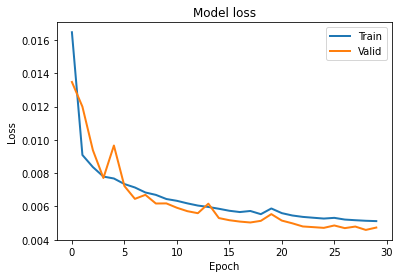

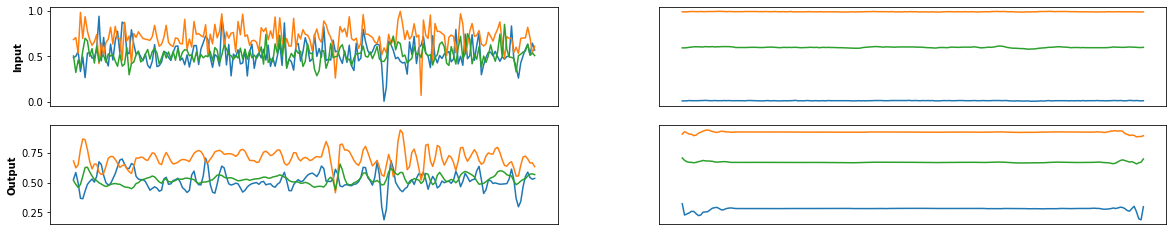

In [19]:
utils.loss_plot(history)
predict = autoencoder.predict(test_X_encoder)
utils.plot_examples(test_X_encoder, predict)

In [20]:
# Guardar el Modelo
autoencoder.save('autoencoder.h5')

In [42]:
autoencoder = keras.models.load_model('autoencoder.h5')

In [43]:
# Carga el modelo
# autoencoder = keras.models.load_model('autoencoder.h5')

encoded = encoder_model(input_window)  # Create encoder model again
    
full_model = Model(input_window, classifier_model(encoded))  # Create the final model Encoder + Dense Layers
    
# take enconder weights a set the weigths to my model classifier
for l1, l2 in zip(full_model.layers[0:12], autoencoder.layers[0:12]):
    l1.set_weights(l2.get_weights())
    
# avoid retrain encoder part again to keep the weights
for layer in full_model.layers[0:12]:
    layer.trainable = False
    
full_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
# full_model.summary()

Epoch 1/10
128/128 [==============================] - 5s 40ms/step - loss: 1.7597 - accuracy: 0.8005 - lr: 0.0010
Epoch 2/10
128/128 [==============================] - 5s 36ms/step - loss: 0.4226 - accuracy: 0.8610 - lr: 0.0010
Epoch 3/10
128/128 [==============================] - 5s 37ms/step - loss: 0.3289 - accuracy: 0.8806 - lr: 0.0010
Epoch 4/10
128/128 [==============================] - 4s 35ms/step - loss: 0.3022 - accuracy: 0.8866 - lr: 0.0010
Epoch 5/10
128/128 [==============================] - 4s 35ms/step - loss: 0.2777 - accuracy: 0.8934 - lr: 0.0010
Epoch 6/10
128/128 [==============================] - 4s 34ms/step - loss: 0.2614 - accuracy: 0.8975 - lr: 0.0010
Epoch 7/10
128/128 [==============================] - 4s 34ms/step - loss: 0.2504 - accuracy: 0.9017 - lr: 0.0010
Epoch 8/10
128/128 [==============================] - 4s 33ms/step - loss: 0.2444 - accuracy: 0.9029 - lr: 0.0010
Epoch 9/10
128/128 [==============================] - 4s 33ms/step - loss: 0.2359 - accu

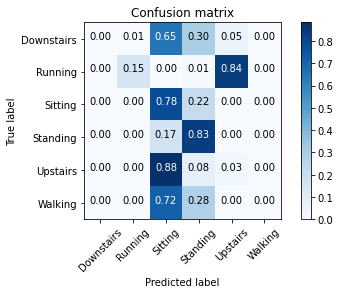

Normalized confusion matrix


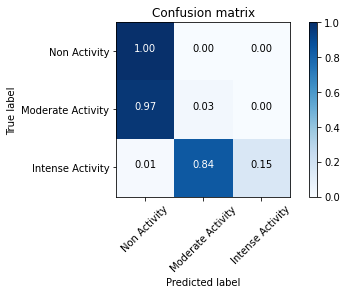

Epoch 1/10
128/128 [==============================] - 4s 35ms/step - loss: 0.2186 - accuracy: 0.9112 - lr: 0.0010
Epoch 2/10
128/128 [==============================] - 4s 34ms/step - loss: 0.2116 - accuracy: 0.9134 - lr: 0.0010
Epoch 3/10
128/128 [==============================] - 5s 35ms/step - loss: 0.2069 - accuracy: 0.9154 - lr: 0.0010
Epoch 4/10
128/128 [==============================] - 5s 36ms/step - loss: 0.2030 - accuracy: 0.9162 - lr: 0.0010
Epoch 5/10
128/128 [==============================] - 5s 36ms/step - loss: 0.2024 - accuracy: 0.9163 - lr: 0.0010
Epoch 6/10
128/128 [==============================] - 4s 35ms/step - loss: 0.1961 - accuracy: 0.9184 - lr: 0.0010
Epoch 7/10
128/128 [==============================] - 5s 38ms/step - loss: 0.1919 - accuracy: 0.9197 - lr: 0.0010
Epoch 8/10
128/128 [==============================] - 5s 37ms/step - loss: 0.1869 - accuracy: 0.9227 - lr: 0.0010
Epoch 9/10
128/128 [==============================] - 5s 37ms/step - loss: 0.1853 - accu

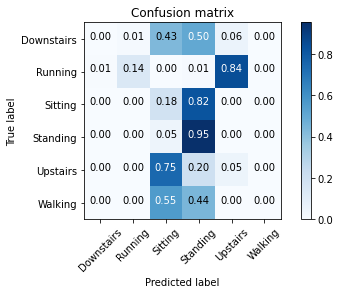

Normalized confusion matrix


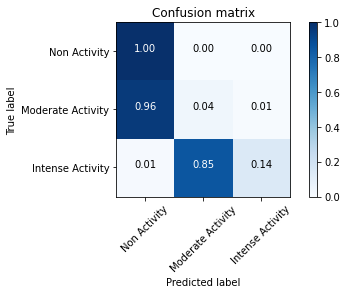

Epoch 1/10
128/128 [==============================] - 5s 38ms/step - loss: 0.1793 - accuracy: 0.9254 - lr: 0.0010
Epoch 2/10
128/128 [==============================] - 5s 36ms/step - loss: 0.1788 - accuracy: 0.9250 - lr: 0.0010
Epoch 3/10
128/128 [==============================] - 5s 38ms/step - loss: 0.1735 - accuracy: 0.9278 - lr: 0.0010
Epoch 4/10
128/128 [==============================] - 5s 37ms/step - loss: 0.1725 - accuracy: 0.9277 - lr: 0.0010
Epoch 5/10
128/128 [==============================] - 5s 39ms/step - loss: 0.1698 - accuracy: 0.9300 - lr: 0.0010
Epoch 6/10
128/128 [==============================] - 5s 37ms/step - loss: 0.1677 - accuracy: 0.9289 - lr: 0.0010
Epoch 7/10
128/128 [==============================] - 4s 31ms/step - loss: 0.1668 - accuracy: 0.9294 - lr: 0.0010
Epoch 8/10
128/128 [==============================] - 4s 32ms/step - loss: 0.1631 - accuracy: 0.9313 - lr: 0.0010
Epoch 9/10
128/128 [==============================] - 4s 31ms/step - loss: 0.1606 - accu

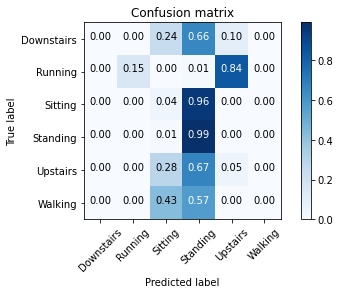

Normalized confusion matrix


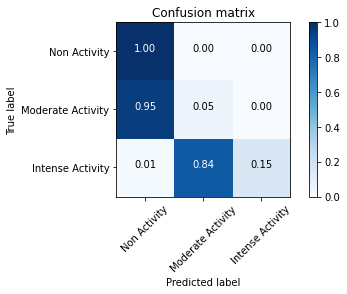

Epoch 1/10
128/128 [==============================] - 4s 33ms/step - loss: 0.1576 - accuracy: 0.9331 - lr: 0.0010
Epoch 2/10
128/128 [==============================] - 4s 31ms/step - loss: 0.1601 - accuracy: 0.9325 - lr: 0.0010
Epoch 3/10
128/128 [==============================] - 4s 31ms/step - loss: 0.1608 - accuracy: 0.9319 - lr: 0.0010
Epoch 4/10
128/128 [==============================] - 4s 32ms/step - loss: 0.1547 - accuracy: 0.9353 - lr: 0.0010
Epoch 5/10
128/128 [==============================] - 4s 31ms/step - loss: 0.1553 - accuracy: 0.9339 - lr: 0.0010
Epoch 6/10
128/128 [==============================] - 4s 35ms/step - loss: 0.1515 - accuracy: 0.9365 - lr: 0.0010
Epoch 7/10
128/128 [==============================] - 4s 35ms/step - loss: 0.1525 - accuracy: 0.9353 - lr: 0.0010
Epoch 8/10
128/128 [==============================] - 4s 34ms/step - loss: 0.1530 - accuracy: 0.9355 - lr: 0.0010
Epoch 9/10
128/128 [==============================] - 4s 33ms/step - loss: 0.1484 - accu

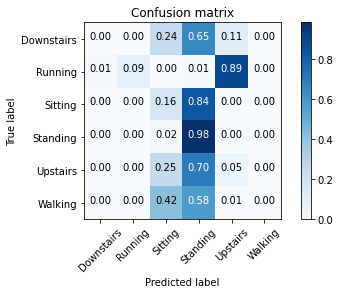

Normalized confusion matrix


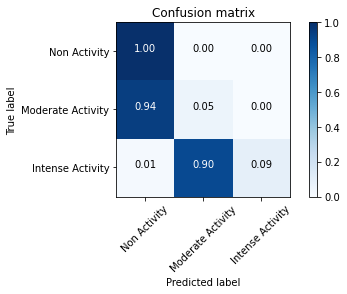

Epoch 1/10
128/128 [==============================] - 4s 30ms/step - loss: 0.1473 - accuracy: 0.9366 - lr: 0.0010
Epoch 2/10
128/128 [==============================] - 3s 24ms/step - loss: 0.1450 - accuracy: 0.9387 - lr: 0.0010
Epoch 3/10
128/128 [==============================] - 3s 24ms/step - loss: 0.1469 - accuracy: 0.9382 - lr: 0.0010
Epoch 4/10
128/128 [==============================] - 3s 24ms/step - loss: 0.1429 - accuracy: 0.9400 - lr: 0.0010
Epoch 5/10
128/128 [==============================] - 3s 24ms/step - loss: 0.1449 - accuracy: 0.9393 - lr: 0.0010
Epoch 6/10
128/128 [==============================] - 3s 24ms/step - loss: 0.1418 - accuracy: 0.9395 - lr: 0.0010
Epoch 7/10
128/128 [==============================] - 3s 24ms/step - loss: 0.1433 - accuracy: 0.9402 - lr: 0.0010
Epoch 8/10
128/128 [==============================] - 3s 24ms/step - loss: 0.1418 - accuracy: 0.9401 - lr: 0.0010
Epoch 9/10
128/128 [==============================] - 3s 24ms/step - loss: 0.1390 - accu

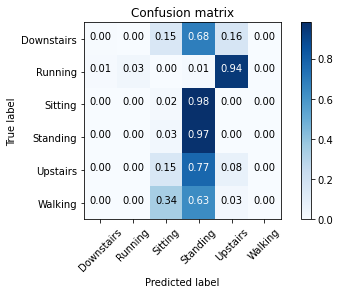

Normalized confusion matrix


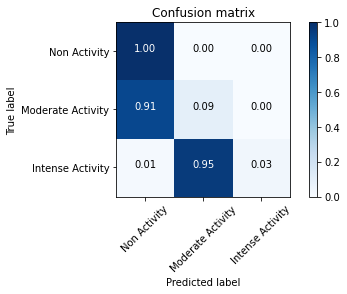

In [46]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Ahora estamos entranando con 80% de los datos
sss_usc = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

for train_index_usc, test_index_usc in sss_usc.split(X_usc, Y_usc):
    X_train_usc, X_test_usc = X_usc[train_index_usc], X_usc[test_index_usc]
    Y_train_usc, Y_test_usc = Y_usc[train_index_usc], Y_usc[test_index_usc]
    
    check = ModelCheckpoint(filepath='usc_had.hdf5', verbose=0, 
                                   save_best_only=True)
    sch = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=5, min_lr=1e-8, verbose=0)
    early_st = EarlyStopping(monitor='val_loss', patience=10,
                                  verbose=0, restore_best_weights=True)
    
    full_model.fit(X_train_wisdm, Y_train_wisdm,callbacks=[early_st,sch,check],
             epochs=10, batch_size=500)
#     , validation_data=(X_test_usc,Y_test_usc
    # METRICS
    # Evaluamos en el conjunto de Test de USC_HAD
    score = full_model.evaluate(X_test_usc, Y_test_usc)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    y_pred = full_model.predict(X_test_usc, verbose=1)  # Predict Results

    y_test_cv = Y_test_usc.argmax(axis=1)
    y_pred_cv = y_pred.argmax(axis=1)
    
    # get f1-score
    f1_macro = f1_score(y_test_cv, y_pred_cv, average='macro')
    f1_weighted = f1_score(y_test_cv, y_pred_cv, average='weighted')
    print('f1_macro:', f1_macro)
    print('f1_weighted:', f1_weighted)

    # get recall
    recall_macro = recall_score(y_test_cv, y_pred_cv, average='macro')
    recall_weighted = recall_score(y_test_cv, y_pred_cv, average='weighted')
    print('recall_macro:', recall_macro)
    print('recall_weighted:', recall_weighted)
    
#     #get ROC AUC
#     roc_auc_score(y_test_cv, y_pred_cv,multi_class="ovr")
#     print('ROC AUC:', roc_auc_score)

    # run confusion matrix
    run.predict_confusion_matrix(y_pred, X_test_usc, Y_test_usc,"results/confusion_matrix_USCHAD.eps")
    create_confusion_matrix(y_pred, X_test_usc, Y_test_usc)

In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import numpy
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def summary_labels(list_har):
    results = []
    for r in list_har:
        if r == 2 or r == 3:
             results.append(0) # Non Activity
        elif r == 0 or r == 4 or r ==5:
            results.append(1) #Moderate Activity
        elif r == 1:
            results.append(2) # Intense Activity
        else:
            print("Non acceptable activity")
    return results
        
def create_confusion_matrix(pred, xTest, yTest):
    
    class_pred=np.zeros(pred.shape)
    
    i=0
    for row in pred:
        class_pred[i, np.argsort(-row)[0]]=1.
        i+=1
    
    # NECESITAMOS AGRUPAR EN 3 CLASES
    # 0,4,5:Moderate 1:Intense 2,3: Non Activity
    test_data = summary_labels(yTest.argmax(axis=1))
    prediction = summary_labels(class_pred.argmax(axis=1))
  
    
    labels = ["Non Activity", "Moderate Activity","Intense Activity"]

    cm= confusion_matrix(numpy.array(test_data),numpy.array(prediction))
    plot_confusion_matrix(cm, labels)